
# **COMP9414 Artificial Intelligence**
## Assignment 1: Constraint Satisfaction Search

@Authors: **Wayne Wobcke, Alfred Krzywicki, Stefano Mezza**

**Due Date:** Week 5, Friday, October 17, 5.00pm

### Objective

This assignment concerns developing optimal solutions to a scheduling problem inspired by the scenario of a manufacturing plant that has to fulfil multiple customer orders with varying deadlines, but where there may be constraints on tasks and on relationships between tasks. Any number of tasks can be scheduled at the same time, but it is possible that some tasks cannot be finished before their deadline. A task finishing late is acceptable, however incurs a cost, which for this assignment is a simple (dollar) amount per hour that the task is late.

A *fuzzy scheduling* problem in this scenario is simplified by ignoring customer orders and having just one machine and a number of *tasks*, each with a fixed duration in hours. Each task must start and finish on the same day, within working hours (9am to 5pm). In addition, there can be *constraints*, both on single tasks and between two tasks. One type of constraint is that a task can have a deadline, which can be “hard” (the deadline must be met in any valid schedule) or “soft” (the task may be finished late &ndash; though still at or before 5pm &ndash; but with a “cost” per hour for missing the deadline). The aim is to develop an overall schedule for all the tasks (in a single week) that minimizes the total cost of all the tasks that finish late, provided that all the hard constraints on tasks are satisfied.

More technically, this assignment is an example of a *constraint optimization problem* (or *constrained optimization problem*), a problem that has constraints like a standard Constraint Satisfaction Problem (CSP), but also a *cost* associated with each solution. For this assignment, we will use a *greedy* algorithm to find optimal solutions to fuzzy scheduling problems that are specified as text strings. However, unlike the greedy search algorithm described in the lectures on search, this greedy algorithm has the property that it is guaranteed to find an optimal solution for any problem (if a solution exists).

The assignment will use the AIPython code of Poole & Mackworth. You are given code to translate fuzzy scheduling problems specified as text strings into CSPs with a cost, and you are given code for several constraint solving algorithms &ndash; based on domain splitting and arc consistency, and based on depth-first search. The assignment will be to implement some missing procedures and to analyse the performance of the constraint solving methods, both analytically and experimentally.

### Submission Instructions

- This is an individual assignment.

- Write your answers in **this** notebook and submit **this** notebook on Moodle under **Assignment 1**.

- Name your submission ``<zid>-<firstname>-<lastname>.ipynb`` where ``<firstname>-<lastname>`` is your **real** (not Moodle) name.

- Make sure you set up AIPython (as done below) so the code can be run on either CSE machines or a marker's own machine.

- Do not submit any AIPython code. Hence do not change any AIPython code to make your code run.

- Make sure your notebook runs cleanly (restart the kernel, clear all outputs and run each cell to check).

- After checking that your notebook runs cleanly, run all cells and submit the notebook **with** the outputs included (do not submit the empty version).

- Make sure images (for plots/graphs) are **included** in the notebook you submit (sometimes images are saved on your machine but are not in the notebook).

- Do not modify the existing code in this notebook except to answer the questions. Marks will be given as and where indicated.

- If you want to submit additional code (e.g. for generating plots), add that at the end of the notebook.

- **Important: Do not distribute any of this code on the Internet. This includes ChatGPT. Do not put this assignment into any LLM.**

### Late Penalties

Standard UNSW late penalties apply (5% of the value of the assignment per day or part day late).

**Note:** Unlike the CSE systems, there is no grace period on Moodle. The due date and time is 5pm **precisely** on Friday October 17.

**Important: You can submit as many times as you want before the due date, but if you do submit before the due date, you cannot submit on Moodle after the due date. If you do not submit before the due date, you can submit on Moodle after the due date.**

### Plagiarism

Remember that ALL work submitted for this assignment must be your own work and no sharing or copying of code or answers is allowed. You may discuss the assignment with other students but must not collaborate on developing answers to the questions. You may use code from the Internet only with suitable attribution of the source. You may not use ChatGPT or any similar software to generate any part of your explanations, evaluations or code. Do not use public code repositories on sites such as github or file sharing sites such as Google Drive to save any part of your work &ndash; make sure your code repository or cloud storage is private and do not share any links. This also applies after you have finished the course, as we do not want next year’s students accessing your solution, and plagiarism penalties can still apply after the course has finished.

All submitted assignments will be run through plagiarism detection software to detect similarities to other submissions, including from past years. You should **carefully** read the UNSW policy on academic integrity and plagiarism (linked from the course web page), noting, in particular, that collusion (working together on an assignment, or sharing parts of assignment solutions) is a form of plagiarism.

Finally, do not use any contract cheating “academies” or online “tutoring” services. This counts as serious misconduct with heavy penalties up to automatic failure of the course with 0 marks, and expulsion from the university for repeat offenders.

### Fuzzy Scheduling

A CSP for this assignment is a set of variables representing tasks, binary constraints on pairs of tasks, and unary constraints (hard or soft) on tasks. The domains are all the working hours in one week, and a task duration is in hours. Days are represented (in the input and output) as strings ‘mon’, ‘tue’, ‘wed’, ‘thu’ and ‘fri’, and times are represented as strings ‘9am’, ‘10am’, ‘11am’, ‘12pm’, ‘1pm’, ‘2pm’, ‘3pm’, ‘4pm’ and ‘5pm’. The only possible values for the start and end times of a task are combinations of a day and times, e.g. ‘mon 9am’. Each task name is a string (with no spaces), and the only soft constraints are the soft deadline constraints.

There are three types of constraint:

- **Binary Constraints:** These specify a hard requirement for the relationship between two tasks.
- **Hard Domain Constraints:** These specify hard requirements for the tasks themselves.
- **Soft Deadline Constraints:** These constraints specify that a task may finish late, but with a given cost.

Each soft constraint has a function defining the *cost* associated with violating the preference, that the constraint solver must minimize, while respecting all the hard constraints. The *cost* of a solution is simply the sum of the costs for the soft constraints that the solution violates (and is always a non-negative integer).

This is the list of possible constraints for a fuzzy scheduling problem (comments below are for explanation and do **not** appear in the input specification; however, the code we supply *should* work with comments that take up a full line): 

```
# binary constraints
constraint, ⟨t1⟩ before ⟨t2⟩           # t1 ends when or before t2 starts
constraint, ⟨t1⟩ after ⟨t2⟩            # t1 starts after or when t2 ends
constraint, ⟨t1⟩ same-day ⟨t2⟩         # t1 and t2 are scheduled on the same day
constraint, ⟨t1⟩ starts-at ⟨t2⟩        # t1 starts exactly when t2 ends

# hard domain constraints
domain, ⟨t⟩, ⟨day⟩, hard                                    # t starts on given day at any time
domain, ⟨t⟩, ⟨time⟩, hard                                   # t starts at given time on any day
domain, ⟨t⟩, starts-before ⟨day⟩ ⟨time⟩, hard               # t starts at or before day, time
domain, ⟨t⟩, starts-after ⟨day⟩ ⟨time⟩, hard                # t starts at or after day, time
domain, ⟨t⟩, ends-before ⟨day⟩ ⟨time⟩, hard                 # t ends at or before day, time
domain, ⟨t⟩, ends-after ⟨day⟩ ⟨time⟩, hard                  # t starts at or after day, time
domain, ⟨t⟩, starts-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard  # day-time range for start time; includes day1, time1 and day2, time2
domain, ⟨t⟩, ends-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard    # day-time range for end time; includes day1, time1 and day2, time2
domain, ⟨t⟩, starts-before ⟨time⟩, hard                     # t starts at or before time on any day
domain, ⟨t⟩, ends-before ⟨time⟩, hard                       # t ends at or before time on any day
domain, ⟨t⟩, starts-after ⟨time⟩, hard                      # t starts at or after time on any day
domain, ⟨t⟩, ends-after ⟨time⟩, hard                        # t ends at or after time on any day

# soft deadline constraint
domain, ⟨t⟩, ends-by ⟨day⟩ ⟨time⟩ ⟨cost⟩, soft          # cost per hour of missing deadline
```

The input specification will consist of several “blocks”, listing the tasks, binary constraints, hard unary constraints and soft deadline constraints for the given problem. A “declaration” of each task will be included before it is used in a constraint. A sample input specification is as follows. Comments are for explanation and do **not** have to be included in the input.

```
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadline constraints
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
```

## Preparation

### 1. Set up AIPython

You will need AIPython for this assignment. To find the aipython files, the aipython directory has to be added to the Python path.

Do this temporarily, as done here, so we can find AIPython and run your code (you will not submit any AIPython code).

You can add either the full path (using `os.path.abspath`), or as in the code below, the relative path.

In [201]:
import sys
sys.path.append('aipython') # change to your directory
sys.path # check that aipython is now on the path

['/Users/yangjiashuo/PycharmProjects/AI_9414',
 '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev',
 '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug',
 '/opt/anaconda3/envs/AI_9414/lib/python313.zip',
 '/opt/anaconda3/envs/AI_9414/lib/python3.13',
 '/opt/anaconda3/envs/AI_9414/lib/python3.13/lib-dynload',
 '',
 '/opt/anaconda3/envs/AI_9414/lib/python3.13/site-packages',
 'aipython',
 'aipython',
 'aipython',
 'aipython',
 'aipython',
 'aipython',
 'aipython',
 'aipython',
 'aipython',
 'aipython',
 'aipython',
 'aipython',
 'aipython']

### 2. Representation of Day Times

Input and output are day time strings such as 'mon 10am' or a range of day time strings such as 'mon 10am-mon 4pm'.

The CSP will represent these as integer hour numbers in the week, ranging from 0 to 39.

The following code handles the conversion between day time strings and hour numbers.

In [202]:
# -*- coding: utf-8 -*-
    
""" day_time string format is a day plus time, e.g. Mon 10am, Tue 4pm, or just Tue or 4pm
    if only day or time, returns day number or hour number only
    day_time strings are converted to and from integer hours in the week from 0 to 39
"""
class Day_Time():
    num_hours_in_day = 8
    num_days_in_week = 5
    
    def __init__(self):
        self.day_names = ['mon','tue','wed','thu','fri']
        self.time_names = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    
    def string_to_week_hour_number(self, day_time_str):
        """ convert a single day_time into an integer hour in the week """
        value = None
        value_type = None
        day_time_list = day_time_str.split()
        if len(day_time_list) == 1:
            str1 = day_time_list[0].strip()
            if str1 in self.time_names: # this is a time
                value = self.time_names.index(str1)
                value_type = 'hour_number'
            else:
                value = self.day_names.index(str1) # this is a day
                value_type = 'day_number'
            # if not day or time, throw an exception
        else:
            value = self.day_names.index(day_time_list[0].strip())*self.num_hours_in_day \
                + self.time_names.index(day_time_list[1].strip())
            value_type = 'week_hour_number'
        return (value_type, value)

    def string_to_number_set(self, day_time_list_str):
        """ convert a list of day-times or ranges 'Mon 9am, Tue 9am-Tue 4pm' into a list of integer hours in the week
            e.g. 'mon 9am-1pm, mon 4pm' -> [0,1,2,3,4,7]
        """
        number_set = set()
        type1 = None
        for str1 in day_time_list_str.lower().split(','):
            if str1.find('-') > 0:
                # day time range
                type1, v1 = self.string_to_week_hour_number(str1.split('-')[0].strip())
                type2, v2 = self.string_to_week_hour_number(str1.split('-')[1].strip())
                if type1 != type2: return None # error, types in range spec are different
                number_set.update({n for n in range(v1, v2+1)})
            else:
                # single day time
                type2, value2 = self.string_to_week_hour_number(str1)
                if type1 != None and type1 != type2: return None # error: type in list is inconsistent
                type1 = type2
                number_set.update({value2})
        return (type1, number_set)
    
    # convert integer hour in week to day time string
    def week_hour_number_to_day_time(self, week_hour_number):
        hour = self.day_hour_number(week_hour_number)
        day = self.day_number(week_hour_number)
        return self.day_names[day]+' '+self.time_names[hour]
    
    # convert integer hour in week to integer day and integer time in day
    def hour_day_split(self, week_hour_number):
        return (self.day_hour_number(week_hour_number), self.day_number(week_hour_number))
    
    # convert integer hour in week to integer day in week
    def day_number(self, week_hour_number):
        return int(week_hour_number / self.num_hours_in_day)
    
    # convert integer hour in week to integer time in day
    def day_hour_number(self, week_hour_number):
        return week_hour_number % self.num_hours_in_day
    
    def __repr__(self):
        day_hour_number = self.week_hour_number % self.num_hours_in_day
        day_number = int(self.week_hour_number / self.num_hours_in_day)
        return self.day_names[day_number]+' '+self.time_names[day_hour_number]

### 3. Constraint Satisfaction Problems with Costs over Tasks with Durations

Since AI Python does not provide the CSP class with an explicit cost, we implement our own class that extends `CSP`.

We also store the cost functions and the durations of all tasks explicitly in the CSP.

The durations of the tasks are used in the `hold` function to evaluate constraints.

In [203]:
from cspProblem import CSP, Constraint

# We need to override Constraint, because tasks have durations
class Task_Constraint(Constraint):
    """A Task_Constraint consists of
    * scope: a tuple of variables
    * spec: text description of the constraint used in debugging
    * condition: a function that can applied to a tuple of values for the variables
    * durations: durations of all tasks
    * func_key: index to the function used to evaluate the constraint
    """
    def __init__(self, scope, spec, condition, durations, func_key):
        super().__init__(scope, condition, spec)
        self.scope = scope
        self.condition = condition
        self.durations = durations
        self.func_key = func_key

    def holds(self, assignment):
        """returns the value of Constraint con evaluated in assignment.

        precondition: all variables are assigned in assignment
        
        CSP has only binary constraints
        condition is in the form week_hour_number1, week_hour_number2
        add task durations as appropriate to evaluate condition
        """
        if self.func_key == 'before':
            # t1 ends before t2 starts, so we need add duration to t1 assignment
            ass0 = assignment[self.scope[0]] + self.durations[self.scope[0]]
            ass1 = assignment[self.scope[1]]
        elif self.func_key == 'after':
            # t2 ends before t1 starts so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        elif self.func_key == 'starts-at':
            # t1 starts exactly when t2 ends, so we need add duration to t2 assignment
            ass0 = assignment[self.scope[0]]
            ass1 = assignment[self.scope[1]] + self.durations[self.scope[1]]
        else:
            return self.condition(*tuple(assignment[v] for v in self.scope))    
        # condition here comes from get_binary_constraint
        return self.condition(*tuple([ass0, ass1]))

# implement nodes as CSP problems with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var, here a task name, to a list of functions for the constraints that apply """
    def __init__(self, domains, durations, constraints, cost_functions, soft_day_time, soft_costs):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.durations = durations
        self.cost_functions = cost_functions
        self.soft_day_time = soft_day_time
        self.soft_costs = soft_costs
        self.cost = self.calculate_cost()

    # specific to fuzzy scheduling CSP problems
    def calculate_cost(self):
        """ this is really a function f = path cost + heuristic to be used by the constraint solver """
        cost = 0
        # TODO: write cost function

        return cost

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"

This formulates a solver for a CSP with cost as a search problem, using domain splitting with arc consistency to define the successors of a node.

In [204]:
from cspConsistency import Con_solver, select, partition_domain 
from searchProblem import Arc, Search_problem
from operator import eq, le, ge

# rewrites rather than extends Search_with_AC_from_CSP
class Search_with_AC_from_Cost_CSP(Search_problem):
    """ A search problem with domain splitting and arc consistency """
    def __init__(self, csp):
        self.cons = Con_solver(csp) # copy of the CSP with access to arc consistency algorithms
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        self.durations = csp.durations
        self.soft_day_time = csp.soft_day_time
        self.soft_costs = csp.soft_costs
        csp.domains = self.domains # after arc consistency
        self.csp = csp

    def is_goal(self, node):
        """ node is a goal if all domains have exactly 1 element """
        return all(len(node.domains[var]) == 1 for var in node.domains)

    def start_node(self):
        return CSP_with_Cost(self.domains, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)

    def neighbors(self, node):
        """returns the neighboring nodes of node.
        """
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1) # chosen at random
        if var:
            dom1, dom2 = partition_domain(node.domains[var])
            self.display(2, "Splitting", var, "into", dom1, "and", dom2)
            to_do = self.cons.new_to_do(var, None)
            for dom in [dom1,dom2]:
                newdoms = node.domains | {var: dom} # overwrite domain of var with dom
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    # all domains are non-empty
                    # make new CSP_with_Cost node to continue the search
                    csp_node = CSP_with_Cost(cons_doms, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2,"...",var,"in",dom,"has no solution")
        return neighs    
    
    def heuristic(self, n):
        return n.cost

### 4. Fuzzy Scheduling Constraint Satisfaction Problems

The following code sets up a CSP problem from a given specification.

Hard (unary) domain constraints are applied to reduce the domains of the variables before the constraint solver runs.

In [205]:
# domain specific CSP builder for week schedule
class CSP_builder():
    # list of text lines without comments and empty lines
    _, default_domain = Day_Time().string_to_number_set('mon 9am-fri 4pm') # should be 0,...,39
    
    # hard unary constraints: domain is a list of values, params is a single value
    # starts-before, ends-before (for starts-before duration should be 0)
    # vals in domain are actual task start/end date/time, so must be val <= whatever is in params
    def apply_before(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 > param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_after(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 < param_val:
                if val in domain: domain.remove(val)
        return domain
    
    # day time range only
    # includes starts-in, ends-in
    # duration is 0 for starts-in, task duration for ends-in
    def apply_in(self, params, duration, domain):
        domain_orig = domain.copy()
        for val in domain_orig: # val is week_hour_number
            # task must be within range
            if val in domain and val+duration not in params:
                domain.remove(val)
        return domain
    
    # task must start at day/time    
    def apply_at(self, param_type, param,domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and param != h:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and param != d:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and param != val:
                if val in domain: domain.remove(val)
        return domain

    # soft deadline constraints: return cost to break constraint
    # ends-by implementation: domain_dt is the day, hour from the domain
    # constr_dt is the soft const spec, dur is the duration of task
    # soft_cost is the unit cost of completion delay
    # so if the tasks starts on domain_dt, it ends on domain_dt+dur
    """
    <t> ends-by <day> <time>, both must be specified
    delay = day_hour(T2) – day_hour(T1) + 24*(D2 - D1), 
    where day_hour(9am) = 0, day_hour(5pm) = 7
    """
    def ends_by(self, domain_dt, constr_dt_str, dur, soft_cost):
        param_type,params = Day_Time().string_to_number_set(constr_dt_str)
        param_val = params.pop()
        dom_h, dom_d = Day_Time().hour_day_split(domain_dt+dur)
        if param_type == 'week_hour_number':
            con_h, con_d = Day_Time().hour_day_split(param_val)
            return 0 if domain_dt + dur <= param_val else soft_cost*(dom_h - con_h + 24*(dom_d - con_d))
        else:
           return None # not good, must be day and time
    
    def no_cost(self, day ,hour):
        return 0
    
    # hard binary constraint, the rest are implemented as gt, lt, eq
    def same_day(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return d1 == d2
        
    # domain is a list of values
    def apply_hard_constraint(self, domain, duration, spec):
        tokens = func_key = spec.split(' ')
        if len(tokens) > 1:
           func_key = spec.split(' ')[0].strip()
           param_type, params = Day_Time().string_to_number_set(spec[len(func_key):])
           if func_key == 'starts-before':
              # duration is 0 for starts before, since we do not modify the time
              return self.apply_before(param_type, params, 0, domain)
           if func_key == 'ends-before':
               return self.apply_before(param_type, params, duration, domain)
           if func_key == 'starts-after':
              return self.apply_after(param_type,params,0,domain)
           if func_key == 'ends-after':
              return self.apply_after(param_type, params, duration, domain)
           if func_key == 'starts-in':
               return self.apply_in(params, 0, domain)
           if func_key == 'ends-in':
               return self.apply_in(params, duration, domain)
        else:
           # here we have task day or time, it has no func key so we need to parse again
           param_type,params = Day_Time().string_to_week_hour_number(spec)
           return self.apply_at(param_type, params, domain)
           
    def get_cost_function(self, spec):
        func_dict = {'ends-by':self.ends_by, 'no-cost':self.no_cost}
        return [func_dict[spec]]
    
    # spec is the text of a constraint, e.g. 't1 before t2'
    # durations are durations of all tasks
    def get_binary_constraint(self, spec, durations):
        tokens = spec.strip().split(' ')
        if len(tokens) != 3: return None # error in spec
        # task1 relation task2
        fun_dict = {'before':le, 'after':ge, 'starts-at':eq, 'same-day':self.same_day}
        return Task_Constraint((tokens[0].strip(), tokens[2].strip()), spec, fun_dict[tokens[1].strip()], durations, tokens[1].strip())
    
    def get_CSP_with_Cost(self, input_lines):
        # Note: It would be more elegant to make task a class but AIpython is not designed for this:
        # CSP_with_Cost inherits from CSP, which takes domains and constraints from all tasks instead of tasks themselves
        domains = dict()
        constraints = []
        cost_functions = dict()
        durations = dict() # durations of tasks
        soft_day_time = dict() # day time specs of soft constraints
        soft_costs = dict() # costs of soft constraints
        
        for input_line in input_lines:
            func_spec = None
            input_line_tokens = input_line.strip().split(',')
            if len(input_line_tokens) != 2: 
                return None # must have number of tokens = 2
            line_token1 = input_line_tokens[0].strip()
            line_token2 = input_line_tokens[1].strip()
            if line_token1 == 'task':
                tokens = line_token2.split(' ')
                if len(tokens) != 2: 
                    return None # must have number of tokens = 3
                key = tokens[0].strip()
                # check the duration and save it
                duration = int(tokens[1].strip())
                if duration > Day_Time().num_hours_in_day: 
                    return None
                durations[key] = duration
                # set zero cost function for this task as default, may add real cost later
                cost_functions[key] = self.get_cost_function('no-cost')
                soft_costs[key] = '0'
                soft_day_time[key] = 'fri 5pm'
                # restrict domain to times that are within allowed range
                # that is start 9-5, start+duration in 9-5
                domains[key] = {x for x in self.default_domain \
                                if Day_Time().day_number(x+duration) \
                                == Day_Time().day_number(x)}
            elif line_token1 == 'domain':
                tokens = line_token2.split(' ')
                if len(tokens) < 2: 
                    return None # must have number of tokens >= 2
                key = tokens[0].strip()
                # if soft constraint, it is handled differently from hard constraints
                if tokens[1].strip() == 'ends-by':
                    # need to retain day time and cost from the line
                    # must have task, 'end-by', day, time, cost
                    # or task, 'end-by', day, cost
                    # or task, 'end-by', time, cost
                    if len(tokens) != 5: 
                        return None 
                    # get the rest of the line after 'ends-by'
                    soft_costs[key] = int(tokens[len(tokens)-1].strip()) # last token is always cost
                    # pass the day time string to avoid passing param_type
                    day_time_str = tokens[2] + ' ' + tokens[3]
                    soft_day_time[key] = day_time_str
                    cost_functions[key] = self.get_cost_function(tokens[1].strip())
                else:
                    # the rest of domain spec, after key, are hard unary domain constraints
                    # func spec has day time, we also need duration
                    dur = durations[key]
                    func_spec = line_token2[len(key):].strip()
                    domains[key] = self.apply_hard_constraint(domains[key], dur, func_spec)       
            elif line_token1 == 'constraint': # all binary constraints
                constraints.append(self.get_binary_constraint(line_token2, durations))
            else:
                return None
            
        return CSP_with_Cost(domains, durations, constraints, cost_functions, soft_day_time, soft_costs)
    
def create_CSP_from_spec(spec: str):
    input_lines = list()
    spec = spec.split('\n')
    # strip comments
    for input_line in spec:
        input_line = input_line.split('#')
        if len(input_line[0]) > 0:
            input_lines.append(input_line[0])
            print(input_line[0])
    # construct initial CSP problem
    csp = CSP_builder()
    csp_problem = csp.get_CSP_with_Cost(input_lines)
    return csp_problem

### 5. Greedy Search Constraint Solver using Domain Splitting and Arc Consistency

Create a GreedySearcher to search over the CSP.

The *cost* function for CSP nodes is used as the heuristic, but is actually a direct estimate of the total path cost function *f* used in A* Search.

In [206]:
from searchGeneric import AStarSearcher

class GreedySearcher(AStarSearcher):
    """ returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """
    def add_to_frontier(self, path):
        """ add path to the frontier with the appropriate cost """
        # value = path.cost + self.problem.heuristic(path.end()) -- A* definition
        value = path.end().cost
        self.frontier.add(path, value)      

Run the GreedySearcher on the CSP derived from the sample input.

**Note: The solution cost will always be 0 (which is wrong for the sample input) until you write the cost function in the cell above.**

In [207]:
# Sample problem specification

sample_spec = """
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadlines
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
"""

In [208]:
# display details (0 turns off)
Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 2
GreedySearcher.max_display_level = 0

def test_csp_solver(searcher):
    final_path = searcher.search()
    if final_path == None:
        print('No solution')
    else:
        domains = final_path.end().domains
        result_str = ''
        for name, domain in domains.items():
            for n in domain:
                result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        print(result_str[1:]+'\ncost: '+str(final_path.end().cost))

csp_problem = create_CSP_from_spec(sample_spec)
solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver)

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
t1: mon 9am
t2: mon 12pm
cost: 0


### 6. Depth-First Search Constraint Solver

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We need to modify this code to make it compatible with the arc consistency solver.

Run the solver by calling `dfs_solve1` (first solution) or `dfs_solve_all` (all solutions).

In [209]:
num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:])

def dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    return list(dfs_solver(csp.constraints, csp.domains, {}, var_order))

def dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run the Depth-First Solver on the sample problem.

**Note: Again there are no costs calculated.**

In [210]:
def test_dfs_solver(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_dfs_solver(csp_problem) # set display to True to see nodes expanded

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
Nodes expanded to reach solution: 5
t1: mon 9am
t2: mon 12pm


### 7. Depth-First Search Constraint Solver using Forward Checking with MRV Heuristic

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We redefine the `dfs_solver` methods to implement the MRV (Minimum Remaining Values) heuristic using forward checking.

Because the AIPython code is designed to manipulate domain sets, we also need to redefine `can_evaluate` to handle partial assignments.

In [211]:
num_expanded = 0
display = False

def can_evaluate(c, assignment):
    """ assignment is a variable:value dictionary
        returns True if the constraint can be evaluated given assignment
    """
    return assignment != {} and all(v in assignment.keys() and type(assignment[v]) != list for v in c.scope)

def mrv_dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp.
        context is an assignment of values to some of the variables.
        var_order is a list of the variables in csp that are not in context.
    """
    global num_expanded, display
    if display:
        print("Context", context)
    to_eval = {c for c in constraints if can_evaluate(c, context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval] # constraints involving unset variables
            var = var_order[0]
            rem_vars = var_order[1:]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                rem_context = context|{var:val}
                # apply forward checking on remaining variables
                if len(var_order) > 1:
                    rem_vars_original = list((v, list(domains[v].copy())) for v in rem_vars)
                    if display:
                        print("Original domains:", rem_vars_original)
                    # constraints that can't already be evaluated in rem_cons
                    rem_cons_ff = [c for c in constraints if c in rem_cons and not can_evaluate(c, rem_context)]
                    for rem_var in rem_vars:
                        # constraints that can be evaluated by adding a value of rem_var to rem_context
                        any_value = list(domains[rem_var])[0]
                        rem_to_eval = {c for c in rem_cons_ff if can_evaluate(c, rem_context|{rem_var: any_value})}
                        # new domain for rem_var are the values for which all newly evaluable constraints hold
                        rem_vals = domains[rem_var].copy()
                        for rem_val in domains[rem_var]:
                            # no constraint with rem_var in the existing context can be violated
                            for c in rem_to_eval:
                                if not c.holds(rem_context|{rem_var: rem_val}):
                                    if rem_val in rem_vals:
                                        rem_vals.remove(rem_val)
                        domains[rem_var] = rem_vals
                        # order remaining variables by MRV
                        rem_vars.sort(key=lambda v: len(domains[v]))
                    if display:
                        print("After forward checking:", list((v, domains[v]) for v in rem_vars))
                if rem_vars == [] or all(len(domains[rem_var]) > 0 for rem_var in rem_vars):
                    yield from mrv_dfs_solver(rem_cons, domains, context|{var:val}, rem_vars)
                # restore original domains if changed through forward checking
                if len(var_order) > 1:
                    if display:
                        print("Restoring original domain", rem_vars_original)
                    for (v, domain) in rem_vars_original:
                        domains[v] = domain
            if display:
                print("Nodes expanded so far:", num_expanded)

def mrv_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    return list(mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order))

def mrv_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    for sol in mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run this solver on the sample problem.

**Note: Again there are no costs calculated.**

In [212]:
def test_mrv_dfs_solver(csp_problem):
    solution = mrv_dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First MRV Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_mrv_dfs_solver(csp_problem) # set display to True to see nodes expanded

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
Nodes expanded to reach solution: 5
t2: mon 12pm
t1: mon 9am


## Assignment

**Name:** Jiashuo Yang

**zID:** z5661162

### Question 1 (4 marks)

Consider the search spaces for the fuzzy scheduling CSP solvers &ndash; domain splitting with arc consistency and the DFS solver (without forward checking).

- Describe the search spaces in terms of start state, successor functions and goal state(s) (1 mark)
- What is the branching factor and maximum depth to find any solution for the two algorithms (ignoring costs)? (1 mark)
- What is the worst case time and space complexity of the two search algorithms? (1 mark)
- Give one example of a fuzzy scheduling problem that is *easier* for the domain splitting with arc consistency solver than it is for the DFS solver, and explain why (1 mark)

For the second and third part-questions, give the answer in a general form in terms of fuzzy scheduling CSP size parameters.

__Answers for Question 1__

1. Domain Splitting + Arc Consistency:

   Start state: Each variable has a complete optional range.

   Successor function: Choose a task and then divide the scope of this task into two, finally eliminating the impossible scenarios

   Goal state: When each task has only one determined time point left and all constraints are met

   DFS:

   Start state: All tasks have not been scheduled.

   Successor function: Choose a task and select a specific scope for it. If conflicts arise later, revert back.

   Goal state: All tasks are specifically arranged and meet the rules.

2. Domain Splitting:

   Branching factor: each split becomes 2

    Maximum depth: $O(n \log d)$ n = tasks' number d = average domain size

   DFS:

   Branching factor: values per variable

    Maximum depth: n

3. Domain Splitting + Arc Consistency: Time complexity: $O(2^n \cdot e \cdot d^3)$ Space complexity: $O(n \cdot d)$

   DFS: Time complexity: $O(d^n)$  Space complexity: $O(n)$

4. Example:
   Four tasks with chain constraints demonstrating AC propagation

   task, t1 2

   task, t2 2

   task, t3 2

   task, t4 2

   Chain of before constraints

   constraint, t1 before t2

   constraint, t2 before t3

   constraint, t3 before t4

   Hard constraint fixing the first task

   domain, t1, mon 9am, hard

   Reason:
   DFS needs to try many combinations, while Domain Splitting converges quickly.

### Question 2 (5 marks)

Define the *cost* function for a fuzzy scheduling CSP (i.e. a node in the search space for domain splitting and arc consistency) as the total cost of the soft deadline constraints violated for all of the variables, assuming that each variable is assigned one of the best possible values from its domain, where a “best” value for a variable *v* is one that has the lowest cost to violate the soft deadline constraint (if any) for that variable *v*.

- Implement the cost function in the indicated cell and place a copy of the code below (3 marks)
- What is its computational complexity (give a general form in terms of fuzzy scheduling CSP size parameters)? (1 mark)
- Show that the cost function *f* never decreases along a path, and explain why this means the search algorithm is optimal (1 mark)

In [213]:
# Code for Question 2
# Place a copy of your code here and run it in the relevant cell

# implement nodes as CSP problems with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var, here a task name, to a list of functions for the constraints that apply """
    def __init__(self, domains, durations, constraints, cost_functions, soft_day_time, soft_costs):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.durations = durations
        self.cost_functions = cost_functions
        self.soft_day_time = soft_day_time
        self.soft_costs = soft_costs
        self.cost = self.calculate_cost()

    # specific to fuzzy scheduling CSP problems
    def calculate_cost(self):
        """ this is really a function f = path cost + heuristic to be used by the constraint solver """
        cost = 0
        # TODO: write cost function
        for var in self.domains:
            if not self.domains[var]:
                continue
            cost_funcs = self.cost_functions.get(var, [])
            min_cost_for_var = float('inf')
            for value in self.domains[var]:
                value_cost = 0
                for cost_func in cost_funcs:
                    func_name = cost_func.__name__
                    if func_name == 'ends_by':
                        result = cost_func(
                            value,
                            self.soft_day_time[var],
                            self.durations[var],
                            self.soft_costs[var]
                        )
                        if result is not None:
                            value_cost += result
                    elif func_name == 'no_cost':
                        value_cost += 0
                min_cost_for_var = min(min_cost_for_var, value_cost)
            if min_cost_for_var != float('inf'):
                cost += min_cost_for_var
        return cost

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"


__Answers for Question 2__

time complexity: $O(n \times d \times c)$ Space complexity: $O(1)$

n = number of variables (tasks)

d = average domain size per variable (number of possible start times)

c = number of cost functions per variable

Domain splitting divides the domain of the parent node into two subsets, and after applying arc consistency, the domain of the child nodes may be further reduced
min{cost(d) | d ∈ Domain_child(v)} ≥ min{cost(d) | d ∈ Domain_parent(v)}
cost(child) = Σ min_cost(v, child) ≥ Σ min_cost(v, parent) = cost(parent)
f(child) ≥ f(parent)
So cost function f never decreases

Because it is monotonous and the greedy search leads to results similar to the optimal results of A*

### Question 3 (4 marks)

Conduct an empirical evaluation of the domain splitting CSP solver using the cost function defined as above compared to using no cost function (i.e. the zero cost function, as originally defined in the above cell). Use the *average number of nodes expanded* as a metric to compare the two algorithms.

- Write a function `generate_problem(n)` that takes an integer `n` and generates a problem specification with `n` tasks and a random set of hard constraints and soft deadline constraints in the correct format for the constraint solvers (2 marks)

Run the CSP solver (with and without the cost function) over a number of problems of size `n` for a range of values of `n`.

- Plot the performance of the two constraint solving algorithms on the above metric against `n` (1 mark)
- Quantify the performance gain (if any) achieved by the use of this cost function (1 mark)

task, t1 4
task, t2 3
task, t3 3
task, t4 2
constraint, t2 before t4
constraint, t2 same-day t4
constraint, t3 before t1
domain, t1 ends-by wed 11am 36
domain, t2 ends-by wed 10am 10
domain, t3 ends-by wed 2pm 49
domain, t4 ends-by mon 1pm 19
task, t1 4
task, t2 3
task, t3 3
task, t4 2
constraint, t2 before t4
constraint, t2 same-day t4
constraint, t3 before t1
domain, t1 ends-by wed 11am 36
domain, t2 ends-by wed 10am 10
domain, t3 ends-by wed 2pm 49
domain, t4 ends-by mon 1pm 19
task, t1 3
task, t2 2
task, t3 1
task, t4 2
constraint, t3 before t4
constraint, t4 before t2
constraint, t2 before t1
domain, t1 ends-by fri 3pm 17
domain, t2 ends-by tue 3pm 41
domain, t3 ends-by tue 9am 22
domain, t4 ends-by wed 1pm 31
task, t1 3
task, t2 2
task, t3 1
task, t4 2
constraint, t3 before t4
constraint, t4 before t2
constraint, t2 before t1
domain, t1 ends-by fri 3pm 17
domain, t2 ends-by tue 3pm 41
domain, t3 ends-by tue 9am 22
domain, t4 ends-by wed 1pm 31
task, t1 2
task, t2 4
task, t3 3
tas

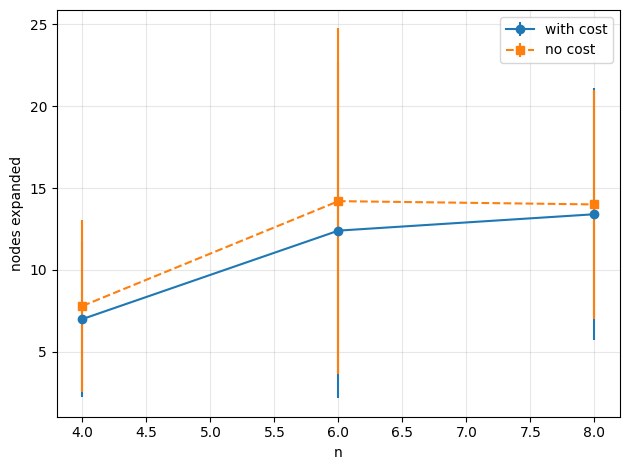

In [214]:
import random
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy


def shengcheng_wenti(n: int, zhongzi: int | None = None,
                     shichang_fanwei=(1, 4), ruan_chengben_fanwei=(10, 50),
                     youxian_p: float = 0.8, tongri_p: float = 0.4) -> str:
    rng = random.Random(zhongzi)
    dt = Day_Time()
    renwu = [f"t{i}" for i in range(1, n + 1)]
    shichang = {t: rng.randint(*shichang_fanwei) for t in renwu}

    hanglie = [f"task, {t} {shichang[t]}" for t in renwu]

    shunxu = renwu[:]
    rng.shuffle(shunxu)
    for i in range(n - 1):
        if rng.random() < youxian_p:
            hanglie.append(f"constraint, {shunxu[i]} before {shunxu[i+1]}")
            if rng.random() < tongri_p:
                hanglie.append(f"constraint, {shunxu[i]} same-day {shunxu[i+1]}")

    for t in renwu:
        ri, shijian = rng.choice(dt.day_names), rng.choice(dt.time_names)
        chengben = rng.randint(*ruan_chengben_fanwei)
        hanglie.append(f"domain, {t} ends-by {ri} {shijian} {chengben}")

    return "\n".join(hanglie)


class Daijiage_CSP_AC_Sousuo_Jishu(Search_with_AC_from_Cost_CSP):
    def __init__(self, csp):
        super().__init__(csp)
        self.zhankaishu = 0

    def neighbors(self, jiedian):
        self.zhankaishu += 1
        return super().neighbors(jiedian)


def shanchu_chengben(csp: CSP_with_Cost) -> CSP_with_Cost:
    goujianqi = CSP_builder()
    wu_chengben = goujianqi.get_cost_function('no-cost')[0]
    return CSP_with_Cost(
        {v: set(vals) for v, vals in csp.domains.items()},
        durations=deepcopy(csp.durations),
        constraints=list(csp.constraints),
        cost_functions={k: [wu_chengben] for k in csp.cost_functions},
        soft_day_time=deepcopy(csp.soft_day_time),
        soft_costs={k: 0 for k in csp.soft_costs}
    )


def _yunxing_yici(n: int, zhongzi: int, shiyong_chengben: bool) -> tuple[int, bool]:
    csp = create_CSP_from_spec(shengcheng_wenti(n, zhongzi=zhongzi))
    if not shiyong_chengben:
        csp = shanchu_chengben(csp)
    wenti = Daijiage_CSP_AC_Sousuo_Jishu(csp)
    lujing = GreedySearcher(wenti).search()
    return wenti.zhankaishu, lujing is not None


def yunxing_shiyan(ns: list[int], shiyanci: int = 10, zhongzi: int = 2025):
    rng = random.Random(zhongzi)
    tongji = {"dai": {n: [] for n in ns}, "wu": {n: [] for n in ns}}

    for n in ns:
        for _ in range(shiyanci):
            s = rng.randrange(1, 10**9)
            tongji["dai"][n].append(_yunxing_yici(n, s, True)[0])
            tongji["wu"][n].append(_yunxing_yici(n, s, False)[0])

    pingjun_dai = [np.mean(tongji["dai"][n]) for n in ns]
    pingjun_wu = [np.mean(tongji["wu"][n]) for n in ns]
    biaozhuncha_dai = [np.std(tongji["dai"][n], ddof=1) for n in ns]
    biaozhuncha_wu = [np.std(tongji["wu"][n], ddof=1) for n in ns]

    print(f"\nNodes expanded (mean ± std, {shiyanci} trials):")
    for i, n in enumerate(ns):
        zengyi = (pingjun_wu[i] - pingjun_dai[i]) / pingjun_wu[i] * 100 if pingjun_wu[i] != 0 else 0
        print(f"n={n}: with cost {pingjun_dai[i]:.1f}±{biaozhuncha_dai[i]:.1f} | "
              f"no cost {pingjun_wu[i]:.1f}±{biaozhuncha_wu[i]:.1f} | gain {zengyi:.1f}%")

    plt.figure(figsize=(6.4, 4.8))
    plt.errorbar(ns, pingjun_dai, yerr=biaozhuncha_dai, marker='o', label='with cost')
    plt.errorbar(ns, pingjun_wu, yerr=biaozhuncha_wu, marker='s', linestyle='--', label='no cost')
    plt.xlabel('n')
    plt.ylabel('nodes expanded')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {"ns": ns, "dai_pingjun": pingjun_dai, "dai_biaozhuncha": biaozhuncha_dai,
            "wu_pingjun": pingjun_wu, "wu_biaozhuncha": biaozhuncha_wu}


Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 0
GreedySearcher.max_display_level = 0

_ = yunxing_shiyan(ns=[4, 6, 8], shiyanci=5, zhongzi=1234)

### Question 4 (5 marks)

Compare the Depth-First Search (DFS) solver to the Depth-First Search solver using forward checking with Minimum Remaining Values heuristic (DFS-MRV). For this question, ignore the costs associated with the CSP problems. 

- What is the worst case time and space complexity of each algorithm (give a general form in terms of fuzzy scheduling problem sizes)? (1 mark)
- What are the properties of the search algorithms (completeness, optimality)? (1 mark)
- Give an example of a problem that is *easier* for the DFS-MRV solver than it is for the DFS solver, and explain why (1 mark)
- Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution (1 mark)
- Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded (1 mark)

For the empirical evaluations, run the two algorithms on a variety of problems of size `n` for varying `n`. Note that the domain splitting CSP solver with costs should always find an optimal solution.

task, t1 2
task, t2 2
task, t3 1
constraint, t3 before t1
constraint, t1 before t3
domain, t1 ends-by wed 11am 10
domain, t2 ends-by mon 2pm 10
domain, t3 ends-by wed 2pm 10
No (more) solutions. Total of 1 paths expanded.
task, t1 2
task, t2 2
task, t3 2
constraint, t1 before t3
constraint, t3 before t2
domain, t1 ends-by wed 4pm 10
domain, t2 ends-by wed 1pm 10
domain, t3 ends-by wed 4pm 10
task, t1 2
task, t2 2
task, t3 2
constraint, t1 before t3
constraint, t3 before t2
domain, t1 ends-by wed 4pm 10
domain, t2 ends-by wed 1pm 10
domain, t3 ends-by wed 4pm 10
task, t1 2
task, t2 2
task, t3 2
constraint, t1 before t3
constraint, t3 before t2
domain, t1 ends-by wed 4pm 10
domain, t2 ends-by wed 1pm 10
domain, t3 ends-by wed 4pm 10
task, t1 1
task, t2 1
task, t3 1
constraint, t2 before t1
constraint, t3 before t1
domain, t1 ends-by tue 4pm 10
domain, t2 ends-by tue 3pm 10
domain, t3 ends-by tue 11am 10
task, t1 1
task, t2 1
task, t3 1
constraint, t2 before t1
constraint, t3 before t1
do

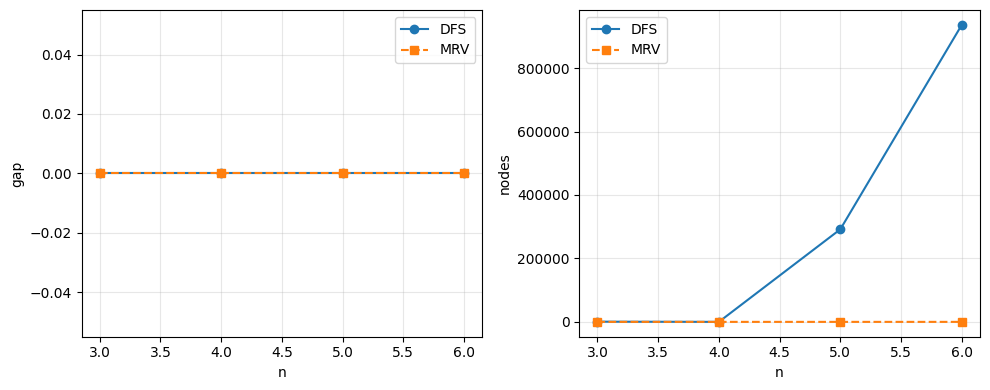

In [215]:
def jisuan_jiejue_chengben(jiejue, csp):
    if jiejue is None: return float('inf')
    zongshu = 0
    for var, val in jiejue.items():
        for f in csp.cost_functions.get(var, []):
            if f.__name__ == 'ends_by':
                r = f(val, csp.soft_day_time[var], csp.durations[var], csp.soft_costs[var])
                if r is not None: zongshu += r
    return zongshu


def dfs_qiujieqi_daitongji(yueshu, yuyu, shangxiawen, bianliang_shunxu, tongji):
    daipinggu = {c for c in yueshu if c.can_evaluate(shangxiawen)}
    if not all(c.holds(shangxiawen) for c in daipinggu): return
    if not bianliang_shunxu:
        yield shangxiawen; return
    var, shengyu = bianliang_shunxu[0], bianliang_shunxu[1:]
    for val in yuyu[var]:
        tongji['nodes_expanded'] += 1
        yield from dfs_qiujieqi_daitongji(yueshu, yuyu, shangxiawen | {var: val}, shengyu, tongji)


def dfs_qiujie1_daitongji(csp, bianliang_shunxu=None):
    tongji = {'nodes_expanded': 0}
    bs = list(csp.domains) if bianliang_shunxu is None else bianliang_shunxu
    for jie in dfs_qiujieqi_daitongji(csp.constraints, csp.domains, {}, bs, tongji):
        return jie, tongji['nodes_expanded']
    return None, tongji['nodes_expanded']


def mrv_dfs_qiujieqi_daitongji(yueshu, yuyu, shangxiawen, bianliang_shunxu, tongji):
    daipinggu = {c for c in yueshu if can_evaluate(c, shangxiawen)}
    if not all(c.holds(shangxiawen) for c in daipinggu): return
    if not bianliang_shunxu:
        yield shangxiawen; return

    var, shengyu = bianliang_shunxu[0], bianliang_shunxu[1:]
    for val in list(yuyu[var]):
        tongji['nodes_expanded'] += 1
        xin_shangxiawen = shangxiawen | {var: val}
        if shengyu:
            kuaizhao = [(v, set(yuyu[v])) for v in shengyu]
            daichuli = [c for c in yueshu if c not in daipinggu]
            for sybl in shengyu:
                yuyu[sybl] = {
                    sybl_zhi for sybl_zhi in yuyu[sybl]
                    if all(c.holds(xin_shangxiawen | {sybl: sybl_zhi})
                           for c in daichuli if can_evaluate(c, xin_shangxiawen | {sybl: sybl_zhi}))
                }
            shengyu.sort(key=lambda v: len(yuyu[v]))
        if not shengyu or all(yuyu[sybl] for sybl in shengyu):
            yield from mrv_dfs_qiujieqi_daitongji(yueshu, yuyu, xin_shangxiawen, shengyu, tongji)
        if shengyu:
            for v, dom in kuaizhao: yuyu[v] = dom


def mrv_dfs_qiujie1_daitongji(csp, bianliang_shunxu=None):
    tongji = {'nodes_expanded': 0}
    bs = sorted(list(csp.domains), key=lambda v: len(csp.domains[v])) if bianliang_shunxu is None else bianliang_shunxu
    for jie in mrv_dfs_qiujieqi_daitongji(csp.constraints, csp.domains, {}, bs, tongji):
        return jie, tongji['nodes_expanded']
    return None, tongji['nodes_expanded']


def shengcheng_jiandan_wenti(n, zhongzi=None):
    rng = random.Random(zhongzi)
    rizi = ['mon','tue','wed']
    shijian = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    renwu = [f"t{i+1}" for i in range(n)]
    shichang  = {t: rng.randint(1, 2) for t in renwu}
    hanglie = [f"task, {t} {shichang[t]}" for t in renwu]
    for _ in range(min(2, n-1)):
        a, b = rng.sample(renwu, 2); hanglie.append(f"constraint, {a} before {b}")
    for t in renwu:
        hanglie.append(f"domain, {t} ends-by {rng.choice(rizi)} {rng.choice(shijian[2:])} 10")
    return "\n".join(hanglie)


def yunxing_bijiao(n, shiyanci=5, zhongzi=2025):
    rng = random.Random(zhongzi)
    dfs_chaju, mrv_chaju, dfs_jiedian, mrv_jiedian = [], [], [], []
    chenggong = 0
    while chenggong < shiyanci:
        s = rng.randrange(1, 10**9)
        guige = shengcheng_jiandan_wenti(n, zhongzi=s)

        csp_zuiyou = create_CSP_from_spec(guige)
        zuiyou_lujing = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_zuiyou)).search()
        if zuiyou_lujing is None: continue
        zuiyou_chengben = zuiyou_lujing.end().cost

        csp_dfs = create_CSP_from_spec(guige)
        dfs_jie, dfs_n = dfs_qiujie1_daitongji(csp_dfs)
        if dfs_jie is None: continue
        dfs_chengben = jisuan_jiejue_chengben(dfs_jie, csp_dfs)

        csp_mrv = create_CSP_from_spec(guige)
        mrv_jie, mrv_n = mrv_dfs_qiujie1_daitongji(csp_mrv)
        if mrv_jie is None: continue
        mrv_chengben = jisuan_jiejue_chengben(mrv_jie, csp_mrv)

        dfs_chaju.append((dfs_chengben - zuiyou_chengben) / max(1, zuiyou_chengben))
        mrv_chaju.append((mrv_chengben - zuiyou_chengben) / max(1, zuiyou_chengben))
        dfs_jiedian.append(dfs_n); mrv_jiedian.append(mrv_n)
        chenggong += 1

    return {
        'dfs_gap': float(np.mean(dfs_chaju)),
        'mrv_gap': float(np.mean(mrv_chaju)),
        'dfs_nodes': float(np.mean(dfs_jiedian)),
        'mrv_nodes': float(np.mean(mrv_jiedian)),
        'success': chenggong
    }

Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 0
GreedySearcher.max_display_level = 0

chicun = [3, 4, 5, 6]
jieguo = {n: yunxing_bijiao(n, shiyanci=5, zhongzi=2025+n) for n in chicun}

for n in chicun:
    r = jieguo[n]
    print(f"n={n} succ={r['success']} | DFS gap={r['dfs_gap']:.3f} nodes={r['dfs_nodes']:.1f} | MRV gap={r['mrv_gap']:.3f} nodes={r['mrv_nodes']:.1f}")

ns = chicun
dg = [jieguo[n]['dfs_gap']  for n in ns]
mg = [jieguo[n]['mrv_gap']  for n in ns]
dn = [jieguo[n]['dfs_nodes'] for n in ns]
mn = [jieguo[n]['mrv_nodes'] for n in ns]

tu, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(ns, dg, 'o-', label='DFS'); ax1.plot(ns, mg, 's--', label='MRV')
ax1.set_xlabel('n'); ax1.set_ylabel('gap'); ax1.legend(); ax1.grid(alpha=0.3)
ax2.plot(ns, dn, 'o-', label='DFS'); ax2.plot(ns, mn, 's--', label='MRV')
ax2.set_xlabel('n'); ax2.set_ylabel('nodes'); ax2.legend(); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.show()

__Answers for Question 4__

DFS:

time complexity: $O(d^ n)$ Space complexity: $O(n)$

DFS-MRV:

time complexity: $O(d^ n)$ Space complexity: $O(n⋅d)$

completeness: If a solution exists, it can ultimately be found.
optimality: Both of these just need to have a solution; an optimal solution is not required

task, t1 2
task, t2 2
task, t3 2
task, t4 2

domain, t1 starts-in mon 9am-mon 9am

constraint, t1 before t2
constraint, t2 before t3
constraint, t3 before t4

MRV first selects the domain with the smallest t1, immediately triggering forward deletion of t2, t3, and t4, greatly reducing subsequent branches, while DFS would generate a large number of invalid attempts

### Question 5 (4 marks)

The DFS solver chooses variables in random order, and systematically explores all values for those variables in no particular order.

Incorporate costs into the DFS constraint solver as heuristics to guide the search. Similar to the cost function for the domain splitting solver, for a given variable *v*, the cost of assigning the value *val* to *v* is the cost of violating the soft deadline constraint (if any) associated with *v* for the value *val*. The *minimum cost* for *v* is the lowest cost from amongst the values in the domain of *v*. The DFS solver should choose a variable *v* with lowest minimum cost, and explore its values in order of cost from lowest to highest.

- Implement this behaviour by modifying the code in `dfs_solver` and place a copy of the code below (2 marks)
- Empirically compare the performance of DFS with and without these heuristics (2 marks)

For the empirical evaluations, again run the two algorithms on a variety of problems of size `n` for varying `n`.

task, t1 4
task, t2 3
task, t3 2
constraint, t3 before t2
domain, t1 ends-by thu 1pm 21
domain, t2 ends-by wed 12pm 32
domain, t3 ends-by fri 12pm 14
task, t1 4
task, t2 3
task, t3 2
constraint, t3 before t2
domain, t1 ends-by thu 1pm 21
domain, t2 ends-by wed 12pm 32
domain, t3 ends-by fri 12pm 14
task, t1 4
task, t2 3
task, t3 2
constraint, t3 before t2
domain, t1 ends-by thu 1pm 21
domain, t2 ends-by wed 12pm 32
domain, t3 ends-by fri 12pm 14
task, t1 3
task, t2 2
task, t3 4
constraint, t2 before t3
constraint, t3 before t1
domain, t1 ends-by tue 11am 37
domain, t2 ends-by tue 12pm 31
domain, t3 ends-by tue 9am 39
task, t1 3
task, t2 2
task, t3 4
constraint, t2 before t3
constraint, t3 before t1
domain, t1 ends-by tue 11am 37
domain, t2 ends-by tue 12pm 31
domain, t3 ends-by tue 9am 39
task, t1 3
task, t2 2
task, t3 4
constraint, t2 before t3
constraint, t3 before t1
domain, t1 ends-by tue 11am 37
domain, t2 ends-by tue 12pm 31
domain, t3 ends-by tue 9am 39
task, t1 2
task, t2 1
tas

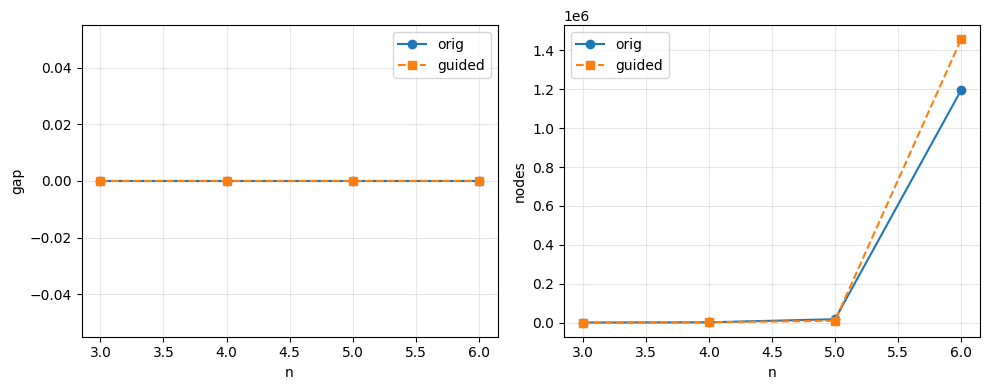

In [216]:
def jisuan_zhi_chengben(var, val, csp):
    if var not in csp.cost_functions: return 0
    zongshu = 0
    for f in csp.cost_functions[var]:
        if f.__name__ == 'ends_by':
            r = f(val, csp.soft_day_time[var], csp.durations[var], csp.soft_costs[var])
            if r is not None: zongshu += r
    return zongshu

def huoqu_zuixiao_chengben(var, yuyu, csp):
    return float('inf') if not yuyu else min(jisuan_zhi_chengben(var, v, csp) for v in yuyu)

def chengben_yindao_dfs_qiujieqi(yueshu, yuyu, shangxiawen, bianliang_shunxu, csp, tongji):
    daipinggu = {c for c in yueshu if c.can_evaluate(shangxiawen)}
    if not all(c.holds(shangxiawen) for c in daipinggu): return
    if not bianliang_shunxu:
        yield shangxiawen; return
    shengyu_yueshu = [c for c in yueshu if c not in daipinggu]
    var = min(bianliang_shunxu, key=lambda v: huoqu_zuixiao_chengben(v, yuyu[v], csp))
    shengyu = [v for v in bianliang_shunxu if v != var]
    for val in sorted(yuyu[var], key=lambda v: jisuan_zhi_chengben(var, v, csp)):
        tongji['nodes_expanded'] += 1
        yield from chengben_yindao_dfs_qiujieqi(shengyu_yueshu, yuyu, shangxiawen | {var: val}, shengyu, csp, tongji)

def chengben_yindao_dfs_qiujie1(csp):
    tongji = {'nodes_expanded': 0}
    bs = list(csp.domains)
    for jie in chengben_yindao_dfs_qiujieqi(csp.constraints, csp.domains, {}, bs, csp, tongji):
        return jie, tongji['nodes_expanded']
    return None, tongji['nodes_expanded']

def yunxing_q5_bijiao(n, shiyanci=10, zhongzi=2025):
    rng = random.Random(zhongzi)
    chaju_yuanshi, jiedian_yuanshi, chaju_yindao, jiedian_yindao = [], [], [], []
    chenggong = 0
    while chenggong < shiyanci:
        guige = shengcheng_wenti(n, zhongzi=rng.randrange(1, 10**9))  # 修正：seed改为zhongzi
        csp_zuiyou = create_CSP_from_spec(guige)
        zuiyou_lujing = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_zuiyou)).search()
        if zuiyou_lujing is None: continue
        zuiyou_chengben = zuiyou_lujing.end().cost

        csp_y = create_CSP_from_spec(guige)
        jie_y, n_y = dfs_qiujie1_daitongji(csp_y)
        if jie_y is None: continue
        chengben_y = jisuan_jiejue_chengben(jie_y, csp_y)

        csp_d = create_CSP_from_spec(guige)
        jie_d, n_d = chengben_yindao_dfs_qiujie1(csp_d)
        if jie_d is None: continue
        chengben_d = jisuan_jiejue_chengben(jie_d, csp_d)

        chaju_yuanshi.append((chengben_y - zuiyou_chengben) / max(1, zuiyou_chengben))
        chaju_yindao.append((chengben_d - zuiyou_chengben) / max(1, zuiyou_chengben))
        jiedian_yuanshi.append(n_y); jiedian_yindao.append(n_d)
        chenggong += 1

    return {
        'original_gap': float(np.mean(chaju_yuanshi)),
        'guided_gap'  : float(np.mean(chaju_yindao)),
        'original_nodes': float(np.mean(jiedian_yuanshi)),
        'guided_nodes'  : float(np.mean(jiedian_yindao)),
        'success': chenggong
    }

def yunxing_q5_shiyan(ceshi_chicun=[4, 6, 8], shiyanci=10, zhongzi=2025):
    Con_solver.max_display_level = 0
    Search_with_AC_from_Cost_CSP.max_display_level = 0
    GreedySearcher.max_display_level = 0

    jieguo = {n: yunxing_q5_bijiao(n, shiyanci=shiyanci, zhongzi=zhongzi+n) for n in ceshi_chicun}
    for n in ceshi_chicun:
        r = jieguo[n]
        print(f"n={n} succ={r['success']} | orig gap={r['original_gap']:.3f} nodes={r['original_nodes']:.1f} | guided gap={r['guided_gap']:.3f} nodes={r['guided_nodes']:.1f}")

    ns = ceshi_chicun
    og = [jieguo[n]['original_gap']   for n in ns]
    gg = [jieguo[n]['guided_gap']     for n in ns]
    on = [jieguo[n]['original_nodes'] for n in ns]
    gn = [jieguo[n]['guided_nodes']   for n in ns]

    tu, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(ns, og, 'o-', label='orig');   ax1.plot(ns, gg, 's--', label='guided')
    ax1.set_xlabel('n'); ax1.set_ylabel('gap'); ax1.legend(); ax1.grid(alpha=0.3)
    ax2.plot(ns, on, 'o-', label='orig');   ax2.plot(ns, gn, 's--', label='guided')
    ax2.set_xlabel('n'); ax2.set_ylabel('nodes'); ax2.legend(); ax2.grid(alpha=0.3)
    plt.tight_layout(); plt.show()
    return jieguo

q5_jieguo = yunxing_q5_shiyan(ceshi_chicun=[3, 4, 5, 6], shiyanci=10, zhongzi=1234)

### Question 6 (3 marks)

The CSP solver with domain splitting splits a CSP variable domain into *exactly two* partitions. Poole & Mackworth claim that in practice, this is as good as splitting into a larger number of partitions. In this question, empirically evaluate this claim for fuzzy scheduling CSPs.

- Write a new `partition_domain` function that partitions a domain into a list of `k` partitions, where `k` is a parameter to the function (1 mark)
- Modify the CSP solver to use the list of `k` partitions and evaluate the performance of the solver using the above metric for a range of values of `k` (2 marks) 

task, t1 3
task, t2 3
task, t3 2
task, t4 2
constraint, t4 before t1
constraint, t3 before t4
domain, t1 ends-by tue 12pm 20
domain, t2 ends-by tue 1pm 10
domain, t3 ends-by tue 12pm 15
domain, t4 ends-by wed 1pm 10
task, t1 3
task, t2 2
task, t3 2
task, t4 2
constraint, t3 same-day t4
constraint, t3 same-day t1
domain, t1 ends-by tue 2pm 10
domain, t2 ends-by mon 2pm 15
domain, t3 ends-by wed 1pm 15
domain, t4 ends-by mon 11am 20
task, t1 3
task, t2 2
task, t3 3
task, t4 3
constraint, t3 before t2
constraint, t1 same-day t4
domain, t1 ends-by tue 11am 20
domain, t2 ends-by wed 12pm 15
domain, t3 ends-by mon 1pm 10
domain, t4 ends-by mon 11am 10
task, t1 2
task, t2 3
task, t3 3
task, t4 3
constraint, t3 before t4
constraint, t2 same-day t1
domain, t1 ends-by tue 11am 15
domain, t2 ends-by wed 2pm 20
domain, t3 ends-by mon 1pm 20
domain, t4 ends-by tue 1pm 15
n=4 k=2 | nodes=16.0 time=0.003s cost=2.5
task, t1 2
task, t2 2
task, t3 2
task, t4 2
constraint, t4 same-day t3
constraint, t1 s

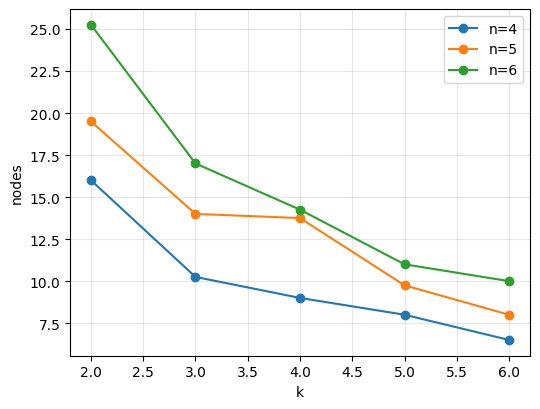

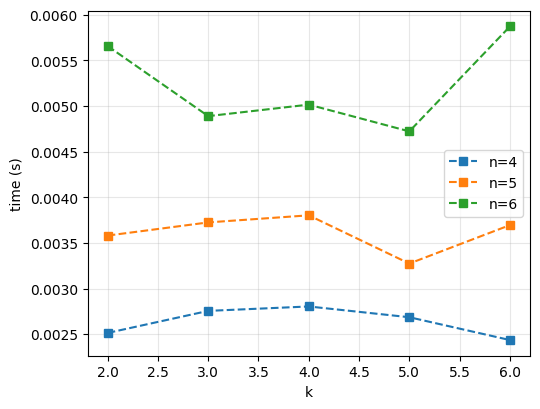

In [217]:
import time

def huafen_yuyu_k_lu(yuyu, k):
    if not yuyu: return []
    if k <= 1: return [set(yuyu)]
    lst = list(yuyu); n = len(lst)
    if n <= k: return [{v} for v in lst]
    q, r = divmod(n, k)
    bufen = [set(lst[i*(q)+(i if i<r else r) : i*(q)+(i if i<r else r) + q + (1 if i<r else 0)]) for i in range(k)]
    return [p for p in bufen if p]

class Daijiage_AC_k_lu_Sousuo(Search_problem):
    def __init__(self, csp, k=2):
        self.yueshuqiujieqi = Con_solver(csp)
        self.yuyu = self.yueshuqiujieqi.make_arc_consistent(csp.domains)
        self.yueshu = csp.constraints
        self.chengben_hanshu = csp.cost_functions
        self.shichang = csp.durations
        self.ruan_ri_shijian = csp.soft_day_time
        self.ruan_chengben = csp.soft_costs
        csp.domains = self.yuyu
        self.csp = csp
        self.k = k
        self.zhankaishu = 0

    def is_goal(self, jiedian):  # 修正：保持父类方法名
        return all(len(jiedian.domains[v]) == 1 for v in jiedian.domains)

    def start_node(self):  # 修正：保持父类方法名
        return CSP_with_Cost(self.yuyu, self.shichang, self.yueshu,
                             self.chengben_hanshu, self.ruan_ri_shijian, self.ruan_chengben)

    def neighbors(self, jiedian):  # 修正：保持父类方法名
        linjiedian = []
        var = select(x for x in jiedian.domains if len(jiedian.domains[x]) > 1)
        if not var: return linjiedian
        self.zhankaishu += 1
        bufen = huafen_yuyu_k_lu(jiedian.domains[var], self.k)
        daiban = self.yueshuqiujieqi.new_to_do(var, None)
        for part in bufen:
            xin_yuyu = jiedian.domains | {var: part}
            yueshu_yuyu = self.yueshuqiujieqi.make_arc_consistent(xin_yuyu, daiban)
            if all(len(yueshu_yuyu[v]) > 0 for v in yueshu_yuyu):
                linjiedian.append(Arc(jiedian, CSP_with_Cost(yueshu_yuyu, self.shichang, self.yueshu,
                                                      self.chengben_hanshu, self.ruan_ri_shijian, self.ruan_chengben)))
        return linjiedian

    def heuristic(self, n):  # 修正：保持父类方法名
        return n.cost

def yong_k_fenge_qiujie(guige, k=2, chaoshi=5):
    kaishi = time.time()
    csp = create_CSP_from_spec(guige)
    sousuo_wenti = Daijiage_AC_k_lu_Sousuo(csp, k=k)
    zuizhong_lujing = GreedySearcher(sousuo_wenti).search()
    yongshi = time.time() - kaishi
    if (zuizhong_lujing is None) or (yongshi > chaoshi): return None
    zhongdian = zuizhong_lujing.end()
    jie = {v: list(zhongdian.domains[v])[0] for v in zhongdian.domains}
    return {'solution': jie, 'cost': zhongdian.cost, 'nodes': sousuo_wenti.zhankaishu,
            'time': yongshi, 'success': True}

def shengcheng_ceshi_wenti(n, zhongzi=None):
    rng = random.Random(zhongzi)
    rizi = ['mon','tue','wed','thu','fri']
    shijianlie = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    renwu = [f"t{i+1}" for i in range(n)]
    shichang  = {t: rng.randint(2, 3) for t in renwu}
    hanglie = [f"task, {t} {shichang[t]}" for t in renwu]
    for _ in range(min(n-1, rng.randint(2, max(2, n//2)))):
        a, b = rng.sample(renwu, 2)
        hanglie.append(f"constraint, {a} {rng.choice(['before','same-day'])} {b}")
    for t in renwu:
        hanglie.append(f"domain, {t} ends-by {rng.choice(rizi[:3])} {rng.choice(shijianlie[2:6])} {rng.choice([10,15,20])}")
    return "\n".join(hanglie)

def shiyan_k_lu(k_zhi=[2,3,4,5], wenti_chicun=[4,5,6], mei_peizhi_shiyanci=5, zhongzi=1234):
    rng = random.Random(zhongzi)
    shuju = {}
    for n in wenti_chicun:
        for k in k_zhi:
            jiedian, shijian, chengben = [], [], []
            while len(jiedian) < mei_peizhi_shiyanci:
                guige = shengcheng_ceshi_wenti(n, zhongzi=rng.randrange(1, 10**9))
                r = yong_k_fenge_qiujie(guige, k=k, chaoshi=10)
                if r and r['success']:
                    jiedian.append(r['nodes']); shijian.append(r['time']); chengben.append(r['cost'])
            shuju[(k,n)] = {'avg_nodes': float(np.mean(jiedian)),
                           'avg_time':  float(np.mean(shijian)),
                           'avg_cost':  float(np.mean(chengben))}
            print(f"n={n} k={k} | nodes={np.mean(jiedian):.1f} time={np.mean(shijian):.3f}s cost={np.mean(chengben):.1f}")
    return {'k_values': k_zhi, 'sizes': wenti_chicun, 'data': shuju}

Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 0
GreedySearcher.max_display_level = 0

jieguo_q6 = shiyan_k_lu(k_zhi=[2,3,4,5,6],
                        wenti_chicun=[4,5,6],
                        mei_peizhi_shiyanci=4,
                        zhongzi=2025)

if jieguo_q6['data']:
    ks, ns, D = jieguo_q6['k_values'], jieguo_q6['sizes'], jieguo_q6['data']

    plt.figure(figsize=(5.5, 4.2))
    for n in ns:
        y = [D[(k,n)]['avg_nodes'] for k in ks]
        plt.plot(ks, y, 'o-', label=f'n={n}')
    plt.xlabel('k'); plt.ylabel('nodes'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    plt.figure(figsize=(5.5, 4.2))
    for n in ns:
        y = [D[(k,n)]['avg_time'] for k in ks]
        plt.plot(ks, y, 's--', label=f'n={n}')
    plt.xlabel('k'); plt.ylabel('time (s)'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()